In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import xarray as xr
import ipywidgets as iw
from importlib import resources
import vmlab

In [2]:
from vmlab.models import fruit_model

### 1 Data aquisition in the field

In [3]:
iw.HBox([
    iw.Image(value=open('./branch_F14_25_photo.png', 'rb').read(), format='png'),
    iw.Image(value=open('./branch_F14_25_recording.png', 'rb').read(), format='png')
])

### 2.1 Encoding as csv, import and visualization

In [ ]:
with resources.path('vmlab.data.trees', 'branch_F14_25.csv') as path:
    branch = pd.read_csv(path)

graph = vmlab.to_graph(branch)
layout = graph.layout_reingold_tilford()
layout.rotate(90)
ig.plot(
    graph, 
    bbox=(0,0,600,250), 
    layout=layout, 
    vertex_label=graph.vs.get_attribute_values('name'), 
    vertex_label_size=10,
    vertex_color=['orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for f, l in zip(
        graph.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph.vs.get_attribute_values('growth__nb_leaf')
    )]
)

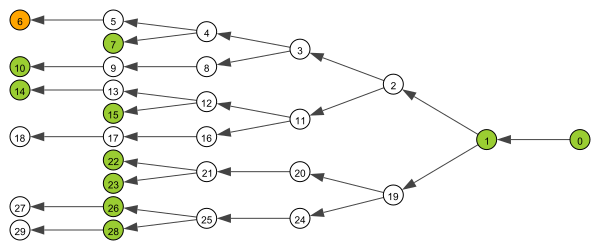

In [6]:
with resources.path('vmlab.data.trees', 'branch_F14_25_empty.csv') as path:
    branch = pd.read_csv(path)

graph = vmlab.to_graph(branch)
layout = graph.layout_reingold_tilford()
layout.rotate(90)
ig.plot(
    graph, 
    bbox=(0,0,600,250), 
    layout=layout, 
    vertex_label=graph.vs.get_attribute_values('name'), 
    vertex_label_size=10,
    vertex_color=['orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for f, l in zip(
        graph.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph.vs.get_attribute_values('growth__radius_gu')
    )]
)

### 2.2 Setup and run simulation

In [7]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=branch,
    start_date='2002-06-01',
    end_date='2003-05-01',
    setup_toml='fruit_model_branch.toml',
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'geometry__interpretation_freq': 5
    },
    output_vars={
        'carbon_flow_coef__distances': 'day',
        'fruit_quality__FM_fruit': 'day',
        'carbon_flow_coef__max_distance_to_fruit': None
    }
)
dataset = vmlab.run(setup, fruit_model, geometry={'size': 1.5, 'size_display': (600, 400)}, batch=('d_max', [
    {'carbon_flow_coef__max_distance_to_fruit': d_max} for d_max in np.linspace(4, 10, 4)
]))

SceneWidget(scenes=[{'id': 's1LHEBvXJcFPDK1Yjau8ntfxi', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

██████████ 100%


### 3 Visualization of model output

In [8]:
ds = dataset.assign_coords({
    'GU': graph.vs.get_attribute_values('name'),
    'GU_': graph.vs.get_attribute_values('name')
})

#### 3.1 Plotting fruit fresh mass for each 'max_distance_to_fruit'

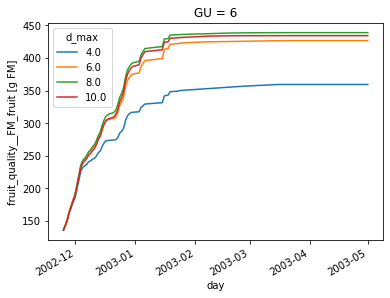

In [9]:
_ = ds.where(ds.fruit_quality__FM_fruit > 0, drop=True).squeeze().fruit_quality__FM_fruit.plot.line(x='day')

#### 3.2 Visualizing carbon flow from source GU to sink GU

In [10]:
layout = graph.layout_reingold_tilford()
layout.rotate(-180)
images = []
for d in range(len(ds.d_max)):
    g = graph.copy()
    distances = ds.carbon_flow_coef__distances[d,-1].data
    edges = np.nonzero(np.isfinite(distances))
    g.add_edges(np.flip(np.transpose(edges), axis=1).astype(np.int64), {'distance': distances[edges]})
    gu_distances = g.es.get_attribute_values('distance')
    images.append(ig.plot(g, layout=layout, bbox=(0,0,300,200), margin=(15,30,30,15),
            vertex_size=15,
            vertex_label_size=8,
            vertex_label=graph.vs.get_attribute_values('name'),
            vertex_color=['orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for f, l in zip(
                g.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
                g.vs.get_attribute_values('growth__nb_leaf')
            )],
            edge_arrow_width=[1.5/(d+1) if d is not None else 0.1 for d in gu_distances],
            edge_arrow_size=[1.5/(d+1) if d is not None else 0.01 for d in gu_distances],
            edge_color=['red' if d is not None else 'black' for d in gu_distances],
            edge_curved=[0.5 if d is not None else 0 for d in gu_distances],
            edge_width=[3/(d+1) if d is not None else 1 for d in gu_distances]
        )      
    )

In [11]:
iw.GridBox([
    iw.HTML(img._repr_svg_()[0]) for img in images
], layout=iw.Layout(grid_template_columns="repeat(2, 400px)"))

GridBox(children=(HTML(value='<?xml version="1.0" encoding="UTF-8"?>\n<svg xmlns="http://www.w3.org/2000/svg" …